In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time

from sklearn.metrics import silhouette_score

# MAKE X AXIS INTEGERS
#from matplotlib.ticker import MaxNLocator
#plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


In [2]:
from subspace_clustering_helper_funcs import *

In [3]:
import warnings
warnings.filterwarnings('ignore')
# C:\Users\kdmen\miniconda3\envs\fl_torch\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning warnings.warn(

- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold

## Loading in the data

In [5]:
# remove pID 101 because it doesn't exist
# remove pID 131 because it  doesnt have enough user defined gestures
# each participant has 100 experimenter defined files and 50 user defined files
# 10 experimenter defined gestures and 5 user defined gestures

file_types = ["IMU_extract", "movavg_files"]
expt_types = ["experimenter-defined"]

#remove participant 131 because they are missing gestures 
pIDs_impaired = ['P102','P103','P104','P105','P106','P107','P108','P109','P110','P111',
       'P112','P114','P115','P116','P118','P119','P121','P122','P123','P124','P125',
       'P126','P127','P128', 'P132']
# remove participants P001 and P003 because they dont have duplicate or open gestures
pIDs_unimpaired = ['P004','P005','P006','P008','P010','P011']

pIDs_both = pIDs_impaired + pIDs_unimpaired

In [6]:
# Kai's laptop
base_path = "C:\\Users\\kdmen\\Desktop\\Research\\Data\\$M\\"
# BRC Desktop
#data_path = "D:\\Kai_MetaGestureClustering_24\\saved_datasets\\"

metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']
metadata_cols_df = pd.read_pickle(base_path+'metadata_cols_df.pkl')

num_rows_per_gesture = 64

# Maximum number of components
max_clusters = 12
num_clusters_range = list(range(2, max_clusters+1))

# Full PCA 20D

In [17]:
print("Loading")
start_time = time.time()

data_path = base_path + "PCA_20D\\"

# Dropping the metadata when we read it in!
training_u_df = pd.read_pickle(data_path+'full_PCA20_training_u_df.pkl').drop(metadata_cols, axis=1)
test_users_df = pd.read_pickle(data_path+'full_PCA20_test_users_df.pkl').drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.2639150619506836s


In [18]:
print(training_u_df.shape)
training_u_df.head()

(327168, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022911,0.066484,0.108729,0.539205,-0.109004,0.104694,0.236364,-0.047925,-0.008163,0.245055,0.128475,0.060089,-0.120963
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368,0.060370,0.074712,0.578903,-0.043638,0.055843,0.255869,-0.044943,-0.031643,0.092175,0.139629,0.037637,-0.143689
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150,0.036385,0.052745,0.568946,-0.093667,0.117103,0.256529,-0.021156,-0.066167,0.144963,0.121987,0.062250,-0.106541
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064307,0.074589,0.053055,0.567871,-0.021066,0.086104,0.246815,-0.021364,-0.042451,0.224192,0.159849,0.042095,-0.073457
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124893,0.114818,0.038629,0.615507,0.001473,0.125932,0.307708,-0.029470,-0.039469,0.181277,0.174820,0.048845,-0.062738


In [19]:
print(test_users_df.shape)
test_users_df.head()

(99584, 20)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
11520,0.068817,0.042105,-0.044102,0.053256,0.080938,0.106052,-0.022074,0.036361,-0.069783,-0.009363,0.155918,-0.009027,0.000214,-0.230086,0.570369,0.194855,-0.057960,-0.306374,-0.006786,0.286192
11521,0.074061,0.047283,-0.042408,0.054238,0.074058,0.102463,-0.015359,0.038657,-0.073920,-0.017767,0.153118,-0.006967,-0.003938,-0.229147,0.571260,0.191396,-0.065188,-0.304010,-0.015377,0.287844
11522,0.079972,0.043184,-0.055275,0.046477,0.079097,0.100367,-0.017235,0.037958,-0.077118,-0.026217,0.158062,-0.015554,0.004638,-0.230422,0.573534,0.184925,-0.078693,-0.309933,-0.010430,0.288559
11523,0.066582,0.035923,-0.040610,0.045127,0.083319,0.103084,-0.026479,0.037963,-0.074882,-0.020223,0.154777,-0.005680,0.004710,-0.233544,0.569960,0.198917,-0.050977,-0.304412,-0.008821,0.283672
11524,0.070243,0.048672,-0.050055,0.045911,0.075328,0.102190,-0.026260,0.038253,-0.068707,-0.025579,0.158595,-0.006139,0.001232,-0.235418,0.572866,0.192559,-0.057381,-0.300236,-0.009044,0.290216


Let's actually re-arrange to make them 3D matrices...

In [20]:
num_gestures = len(training_u_df) // num_rows_per_gesture
num_features = training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
data_np = training_u_df.to_numpy()
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
PCA_np = data_np.reshape(num_gestures, num_rows_per_gesture, num_features)

#PCA_np = PCA_df.to_numpy()
flattened_PCA = PCA_np.reshape(num_gestures, -1)

Now proceed with the clustering

In [21]:
PCA_np.shape

(5112, 64, 20)

In [22]:
flattened_PCA.shape

(5112, 1280)

## K-Means Full Evaluation

In [23]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', flattened_PCA, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


## Silhouette Score
- 1 is the best, -1 is the worst, 0 indicates overlapping clusters. Negative means that a sample has been assigned to the wrong cluster, as a different cluster is more similar
> HIGHER IS BETTER

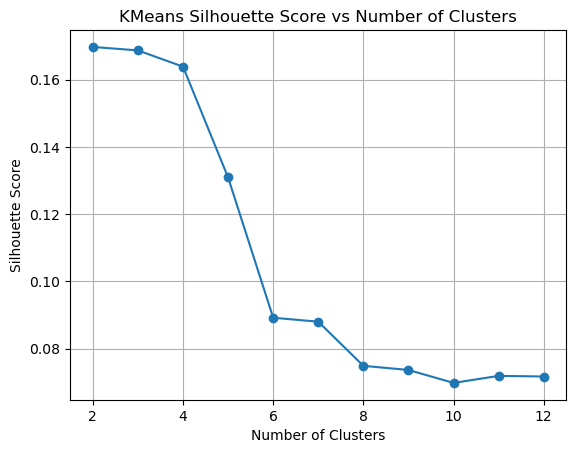

In [24]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

## Davies-Bouldin score
- The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.
- The minimum score is zero, with lower values indicating better clustering.
> LOWER IS BETTER

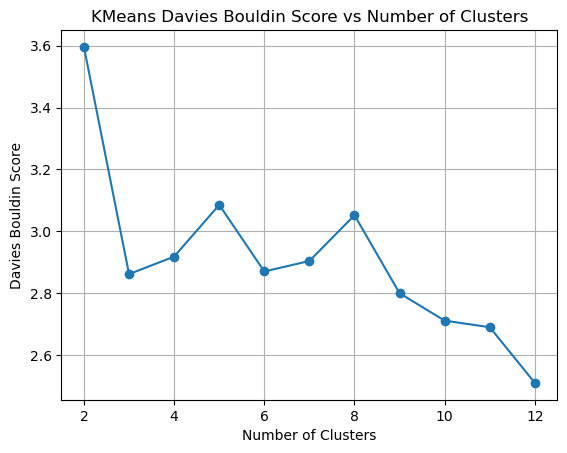

In [25]:
# Plot the Davies-Bouldin score
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

## Calinski and Harabasz score / Variance Ratio Criterion
- The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion.
- The value of k that yields the maximum CH index is chosen as the optimal number of clusters.
> HIGHER IS BETTER

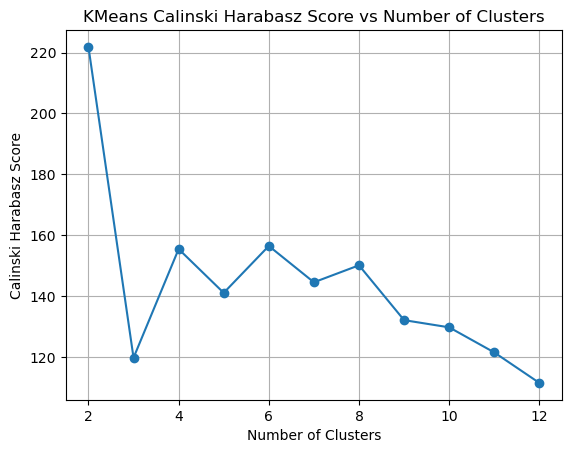

In [26]:
# Plot the Calinski and Harabasz score
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

## Dunn Index
- Measures the compactness and separation of clusters. It is the ratio of the smallest distance between observations not in the same cluster to the largest intra-cluster distance. 
> HIGHER IS BETTER

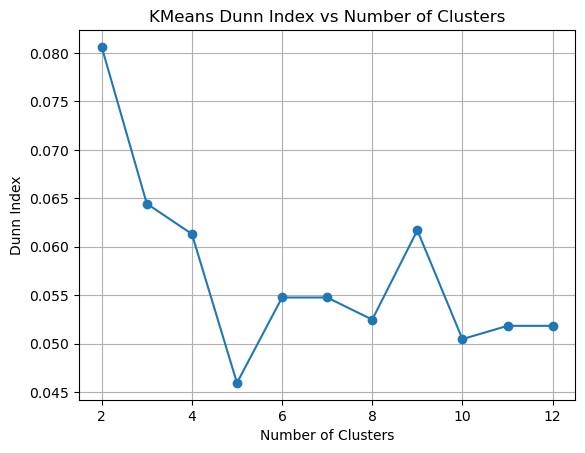

In [27]:
# Plot the Dunn Index
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

## Gap Statistic / Criterion
- Measures the difference between the intra-cluster dispersion of the data and that expected under a null reference distribution.
> HIGHER IS BETTER

> Not sure what mine being negative implies... presumably is broken? Gap(k) = E[log(W_k)] - log(W_k)

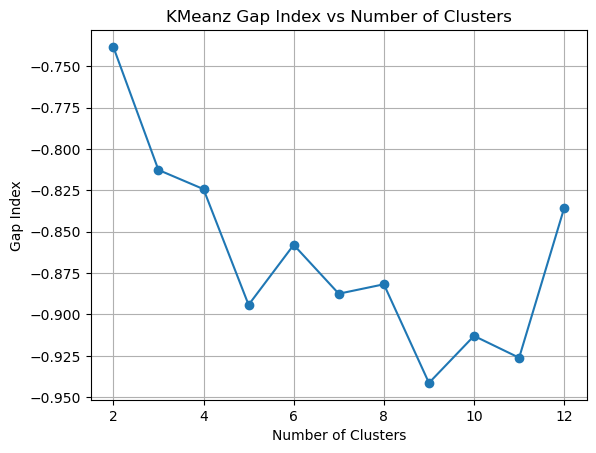

In [28]:
# Plot the Gap Statistic
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeanz Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()

In [29]:
opt_silhouette_lst=[]
opt_davies_bouldin_lst=[]
opt_cali_har_lst=[]
opt_dunn_index_lst=[]
opt_gap_stat_lst=[]
# Eps is only used for DBSCAN, or when OPTICS uses DBSCAN for its clustering (it deosnt by default)
#eps_conditions=[0.1, 0.25, 0.5, 0.75, 1.0]
min_samples_conditions=[1,3,5,10]
#for ep in eps_conditions:
for ms in min_samples_conditions:
    print(f"min_samples={ms}") #eps={ep}, 
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('OPTICS', flattened_PCA, min_samples=ms) #eps=ep, 
    opt_silhouette_lst.append(silhouette)
    opt_davies_bouldin_lst.append(db_index)
    opt_cali_har_lst.append(ch_index)
    opt_dunn_index_lst.append(di_index)
    opt_gap_stat_lst.append(gap_stat)

min_samples=1


NameError: name 'OPTICS' is not defined

## Dynamic Time Warping (DTW)
> Need to install some other package...

In [ ]:
#from tslearn.clustering import TimeSeriesKMeans
#from tslearn.metrics import dtw
#from tslearn.preprocessing import TimeSeriesScalerMeanVariance
#
## Scale the time series data
#scaler = TimeSeriesScalerMeanVariance()
#scaled_data = scaler.fit_transform(gestures_data)
#
## Apply KMeans with DTW as a metric
#dtw_kmeans = TimeSeriesKMeans(n_clusters=5, metric="dtw", random_state=42)
#dtw_labels = dtw_kmeans.fit_predict(scaled_data)
#
## Evaluate clustering with silhouette score
#dtw_silhouette = silhouette_score(scaled_data.reshape(num_gestures, -1), dtw_labels)
#
#print(f"DTW KMeans Silhouette Score: {dtw_silhouette}")

In [ ]:
assert(1==0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_shape):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_shape[0], 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_shape[0], kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Convert data to PyTorch tensors
gestures_data = torch.tensor(np.random.rand(100, 16, 64), dtype=torch.float32)

# Define the model
input_shape = (16, 64)  # Assuming input shape is channels x time_steps
autoencoder = Autoencoder(input_shape)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training the autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = autoencoder(gestures_data.transpose(1, 2))  # Transpose to match input shape
    loss = criterion(outputs, gestures_data.transpose(1, 2))  # Transpose back for loss calculation
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Extract encoder part
encoder = nn.Sequential(*list(autoencoder.encoder.children()))

# Encode the gestures
encoded_gestures = encoder(gestures_data.transpose(1, 2)).detach().numpy()  # Transpose for encoding
encoded_gestures_flattened = encoded_gestures.reshape(encoded_gestures.shape[0], -1)

# Perform clustering on the encoded data
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(encoded_gestures_flattened)

# Evaluate clustering with silhouette score
kmeans_silhouette = silhouette_score(encoded_gestures_flattened, kmeans_labels)
print(f"KMeans Silhouette Score on Encoded Data: {kmeans_silhouette}")

## Choosing Optimal Number of Clusters

In [ ]:
assert(1==0)

> Elbow Plot

In [ ]:
from sklearn.cluster import KMeans

# determining the maximum number of clusters 
# using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)
 
# wcss - within cluster sum of squared distances
wcss = {}
 
for k in range(2,limit+1):
    model = KMeans(n_clusters=k)
    model.fit(dataset_new)
    wcss[k] = model.inertia_
     
# plotting the wcss values to find the elbow value
plt.plot(wcss.keys(), wcss.values(), 'gs-')
plt.xlabel('Values of "k"')
plt.ylabel('WCSS')
plt.show()

# determining the maximum number of clusters using the simple method
limit = int((dataset_new.shape[0]//2)**0.5)

> Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

for k in range(2, limit+1):
    model = KMeans(n_clusters=k)
    model.fit(dataset_new)
    pred = model.predict(dataset_new)
    score = silhouette_score(dataset_new, pred)
    print('Silhouette Score for k = {}: {:<.3f}'.format(k, score))

# EMG Only Dataset Clustering

## EMG Only: PCA 8D

In [30]:
print("Loading")
start_time = time.time()

data_path = base_path + "EMG_PCA8\\"

# Dropping the metadata when we read it in!
emg8_training_u_df = pd.read_pickle(data_path+'emg_PCA8_training_u_df.pkl').drop(metadata_cols, axis=1)
emg8_test_users_df = pd.read_pickle(data_path+'emg_PCA8_test_users_df.pkl').drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.3803389072418213s


In [31]:
print(emg8_training_u_df.shape)
emg8_training_u_df.head()

(327168, 8)


,0,1,2,3,4,5,6,7
0,-0.027903,0.001411,-0.019509,0.013428,-0.019699,0.027333,-0.031254,-0.022911
1,-0.038982,0.006470,-0.000111,0.010904,-0.015323,0.031336,-0.007901,-0.027368
2,-0.116782,0.003824,0.011550,-0.014612,-0.093325,0.081718,-0.013155,-0.046150
3,-0.030245,-0.017409,0.022540,-0.048905,-0.029129,0.090026,-0.024645,-0.064308
4,-0.112950,0.026262,0.004837,-0.063254,-0.108892,0.198729,-0.010583,-0.124894


In [32]:
print(emg8_test_users_df.shape)
emg8_test_users_df.head()

(99584, 8)


,0,1,2,3,4,5,6,7
11520,0.068817,0.042105,-0.044102,0.053256,0.080938,0.106052,-0.022074,0.036361
11521,0.074061,0.047283,-0.042408,0.054238,0.074058,0.102463,-0.015359,0.038657
11522,0.079972,0.043184,-0.055275,0.046477,0.079097,0.100367,-0.017235,0.037957
11523,0.066582,0.035923,-0.040610,0.045127,0.083319,0.103084,-0.026479,0.037962
11524,0.070243,0.048672,-0.050055,0.045911,0.075328,0.102190,-0.026261,0.038253


In [33]:
num_gestures = len(emg8_training_u_df) // num_rows_per_gesture
num_features = emg8_training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(emg8_training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
emg8_PCA_np = emg8_training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
emg8_flattened_PCA = emg8_PCA_np.reshape(num_gestures, -1)

In [34]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', emg8_flattened_PCA, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


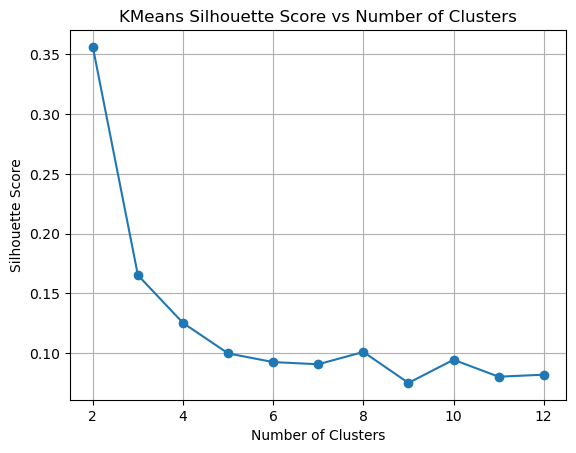

In [35]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

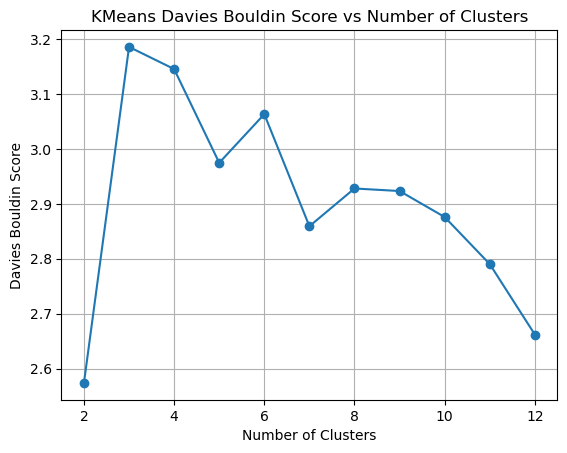

In [36]:
# Plot the Davies-Bouldin score
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

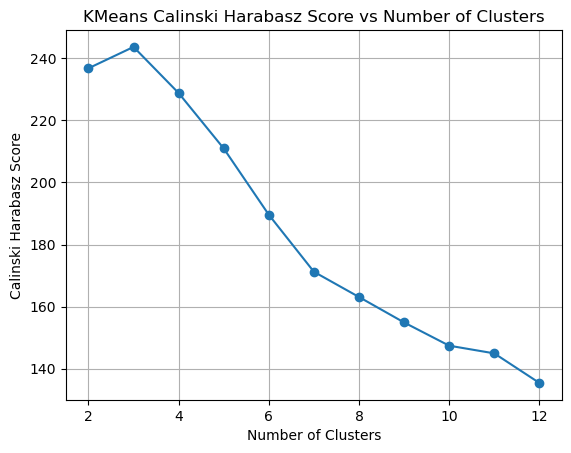

In [37]:
# Plot the Calinski and Harabasz score
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

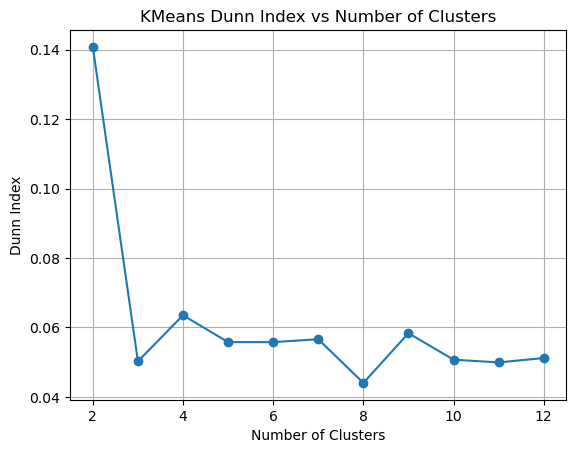

In [38]:
# Plot the Dunn Index
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

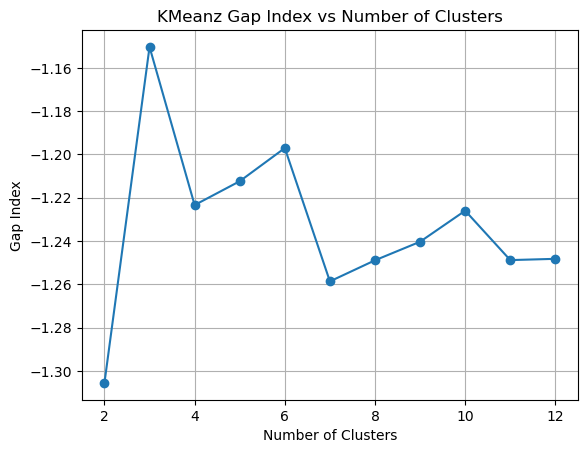

In [39]:
# Plot the Gap Statistic
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeanz Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()

## EMG Only: PCA 3D

In [7]:
print("Loading")
start_time = time.time()

data_path = base_path + "EMG_PCA3\\"

# Dropping the metadata when we read it in!
emg3_training_u_df = pd.read_pickle(data_path+'emg_PCA3_training_u_df.pkl').drop(metadata_cols, axis=1)
emg3_test_users_df = pd.read_pickle(data_path+'emg_PCA3_test_users_df.pkl').drop(metadata_cols, axis=1)

end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.23379015922546387s


In [8]:
print(emg3_training_u_df.shape)
emg3_training_u_df.head()

(327168, 3)


,0,1,2
0,-0.027903,0.001411,-0.019509
1,-0.038982,0.006470,-0.000111
2,-0.116782,0.003824,0.011550
3,-0.030245,-0.017409,0.022540
4,-0.112950,0.026262,0.004837


In [9]:
print(emg3_test_users_df.shape)
emg3_test_users_df.head()

(99584, 3)


,0,1,2
11520,0.068817,0.042105,-0.044102
11521,0.074061,0.047283,-0.042408
11522,0.079972,0.043184,-0.055275
11523,0.066582,0.035923,-0.040610
11524,0.070243,0.048672,-0.050055


In [10]:
num_gestures = len(emg3_training_u_df) // num_rows_per_gesture
num_features = emg3_training_u_df.shape[1]

# Ensure the data can be evenly divided into gestures
assert len(emg3_training_u_df) % num_rows_per_gesture == 0, "The total number of rows is not a multiple of the number of rows per gesture."

# Convert DataFrame to NumPy array
# Reshape into (batch_dim, time_step, n_features) AKA (n_gestures, n_rows_per_gesture, n_columns)
emg3_PCA_np = emg3_training_u_df.to_numpy().reshape(num_gestures, num_rows_per_gesture, num_features)
emg3_flattened_PCA = emg3_PCA_np.reshape(num_gestures, -1)

In [45]:
km_silhouette_lst=[]
km_davies_bouldin_lst=[]
km_cali_har_lst=[]
km_dunn_index_lst=[]
km_gap_stat_lst=[]
for n in num_clusters_range:
    print(f"{n}/{num_clusters_range[-1]}")
    silhouette, db_index, ch_index, di_index, gap_stat = run_clustering_algorithm('KMeans', emg3_flattened_PCA, num_clusters=n)
    km_silhouette_lst.append(silhouette)
    km_davies_bouldin_lst.append(db_index)
    km_cali_har_lst.append(ch_index)
    km_dunn_index_lst.append(di_index)
    km_gap_stat_lst.append(gap_stat)

2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12


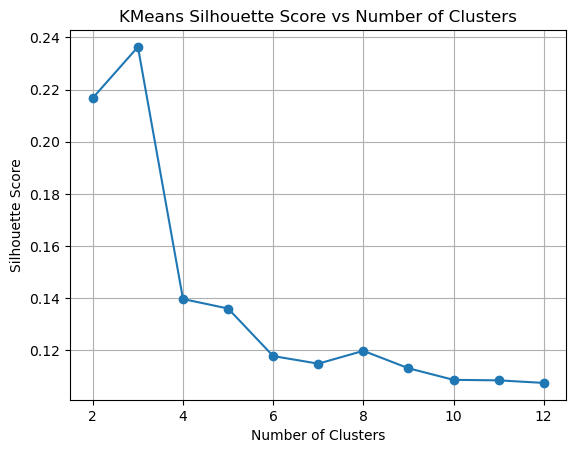

In [46]:
# Plot the silhouette scores
plt.plot(num_clusters_range, km_silhouette_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

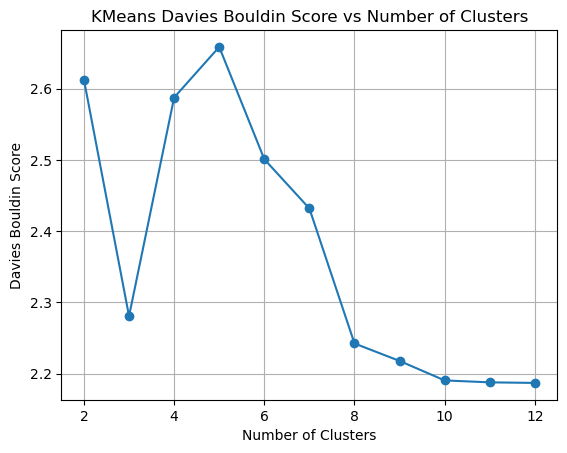

In [47]:
# Plot the Davies-Bouldin score
plt.plot(num_clusters_range, km_davies_bouldin_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies Bouldin Score')
plt.title('KMeans Davies Bouldin Score vs Number of Clusters')
plt.grid(True)
plt.show()

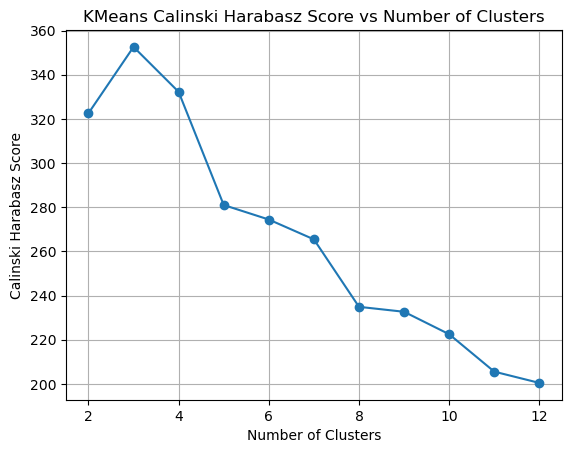

In [48]:
# Plot the Calinski and Harabasz score
plt.plot(num_clusters_range, km_cali_har_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski Harabasz Score')
plt.title('KMeans Calinski Harabasz Score vs Number of Clusters')
plt.grid(True)
plt.show()

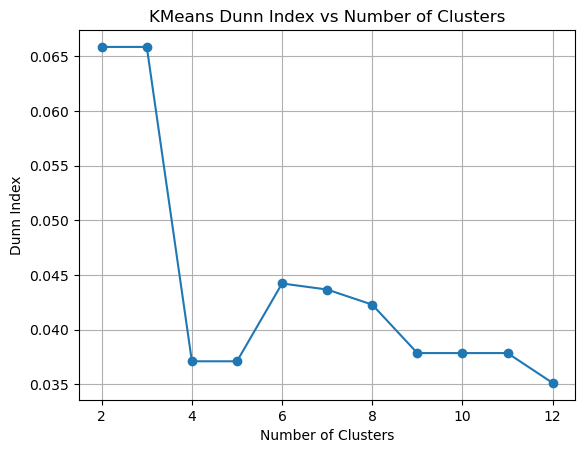

In [49]:
# Plot the Dunn Index
plt.plot(num_clusters_range, km_dunn_index_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Dunn Index')
plt.title('KMeans Dunn Index vs Number of Clusters')
plt.grid(True)
plt.show()

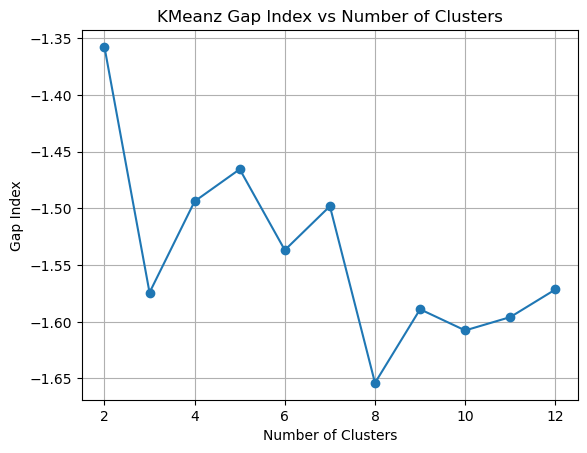

In [50]:
# Plot the Gap Statistic
plt.plot(num_clusters_range, km_gap_stat_lst, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Gap Index')
plt.title('KMeanz Gap Index vs Number of Clusters')
plt.grid(True)
plt.show()

Also, since this data is in 3D, let's go ahead and plot the PCA outputs directly to see if there are clear clusters in 3D

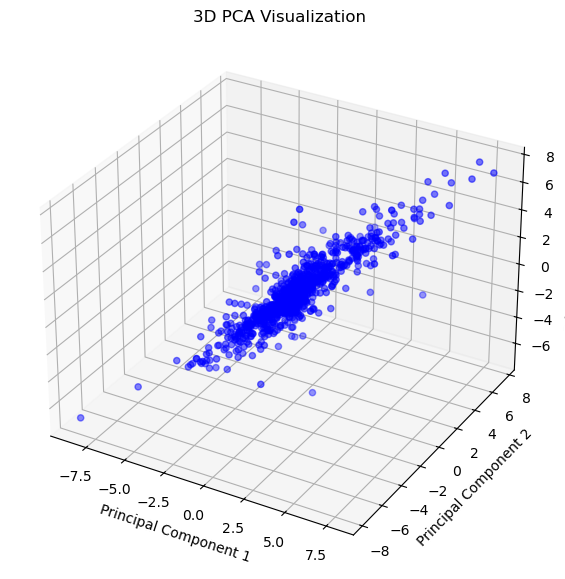

In [11]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
ax.scatter(emg3_PCA_np[:, 0], emg3_PCA_np[:, 1], emg3_PCA_np[:, 2], c='b', marker='o')

# Setting labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Visualization')

plt.show()